Portfolio simulation that trades the index constituents of the Dow Jones Industrial Average.

For each of the 30 member stocks, check each day if the price is above/below its respective 100 day moving average.

In [3]:
%matplotlib inline

from zipline import run_algorithm
from zipline.api import order_target_percent, record, symbol
from datetime import datetime
import pytz
import matplotlib.pyplot as plt
import pandas as pd

In [2]:
def initialize(context):
    # Which stocks to trade
    # NOTE: We specifically set investment universe to CURRENT constituents of Dow Jones Index.
    #       Back in 2003 (start of simulation), the index did not have the same members.
    #       So this is a pick of stocks that we already know had large gains in the past.
    dji = [
        "AAPL",
        "AXP",
        "BA",
        "CAT",
        "CSCO",
        "CVX",
        "DIS",
        "DWDP",
        "GS",
        "HD",
        "IBM",
        "INTC",
        "JNJ",
        "JPM",
        "KO",
        "MCD",
        "MMM",
        "MRK",
        "MSFT",
        "NKE",
        "PFE",
        "PG",
        "TRV",
        "UNH",
        "UTX",
        "V",
        "VZ",
        "WBA",
        "WMT",
        "XOM",  
    ]
    
    # make a list of symbols from tickers
    context.dji_symbols = [symbol(s) for s in dji]
    
    # moving average window
    context.index_average_window = 100

In [4]:
def handle_data(context, data):
    
    # Fetch historical data for all stocks
    stock_hist = data.history(context.dji_symbols, "close", context.index_average_window, "1d")
    
    stock_analytics = pd.DataFrame()
    
    # Is stock above/below average? (True/False) Compare last price with mean price.
    stock_analytics['above_mean'] = stock_hist.iloc[-1] > stock_hist.mean()
    
    # Set weight for stocks to buy.
    #  loc finds where 'above_mean' is True, and sets the column weight.
    #  Weight is 1 divided by total index stocks.
    stock_analytics.loc[stock_analytics['above_mean'] == True, 'weight'] = 1/len(context.dji_symbols)
    stock_analytics.loc[stock_analytics['above_mean'] == False, 'weight'] = 0.0
    
    # place trades
    for stock, analytics in stock_analytics.iterrows():
        # check if stock can be traded
        if data.can_trade(stock):
            order_target_percent(stock, analytics['weight'])

In [5]:
def analyze(context, perf):
    fig = plt.figure(figsize=(12, 8))
    
    # First chart
    ax = fig.add_subplot(311)
    ax.set_title('Strategy Results')
    ax.plot(perf['portfolio_value'], linestyle='-', label='Equity Curve', linewidth=3.0)
    ax.legend()
    ax.grid(False)
    
    # Second chart
    ax = fig.add_subplot(312)
    ax.plot(perf['gross_leverage'], label='Exposure', linestyle='-', linewidth=1.0)
    ax.legend()
    ax.grid(True)

    # Third chart
    ax = fig.add_subplot(313)
    ax.plot(perf['returns'], label='Returns', linestyle='-.', linewidth=1.0)
    ax.legend()
    ax.grid(True)

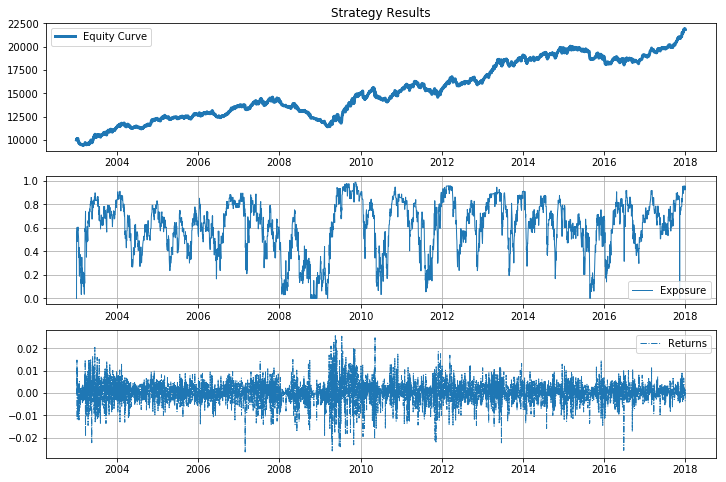

In [6]:
# Set start and end date
start = datetime(2003, 1, 1, tzinfo=pytz.UTC)
end = datetime(2017, 12, 31, tzinfo=pytz.UTC)

# Fire off the backtest
# https://www.zipline.io/appendix.html
results = run_algorithm(
    start=start, 
    end=end, 
    initialize=initialize, 
    analyze=analyze, 
    handle_data=handle_data, 
    capital_base=10000, 
    data_frequency='daily', 
    bundle='quandl') 

In [7]:
results.head()

,algo_volatility,algorithm_period_return,alpha,benchmark_period_return,benchmark_volatility,beta,capital_used,ending_cash,ending_exposure,ending_value,...,short_exposure,short_value,shorts_count,sortino,starting_cash,starting_exposure,starting_value,trading_days,transactions,treasury_period_return
2003-01-02 21:00:00+00:00,NaN,0.000000,None,0.0,NaN,None,0.000000,10000.000000,0.00,0.00,...,0.0,0.0,0,NaN,10000.000000,0.00,0.00,1,[],0.0
2003-01-03 21:00:00+00:00,0.002989,-0.000266,None,0.0,0.0,None,-5038.482910,4961.517090,5035.82,5035.82,...,0.0,0.0,0,-11.224972,10000.000000,0.00,0.00,2,"[{'commission': None, 'price': 13.916955, 'dt'...",0.0
2003-01-06 21:00:00+00:00,0.136767,0.014517,None,0.0,0.0,None,-335.323575,4626.193515,5518.98,5518.98,...,0.0,0.0,0,499.790886,4961.517090,5035.82,5035.82,3,"[{'commission': None, 'price': 57.378675, 'dt'...",0.0
2003-01-07 21:00:00+00:00,0.131208,0.010623,None,0.0,0.0,None,-620.973320,4005.220195,6101.01,6101.01,...,0.0,0.0,0,22.036096,4626.193515,5518.98,5518.98,4,"[{'commission': None, 'price': 72.73635, 'dt':...",0.0
2003-01-08 21:00:00+00:00,0.152270,-0.001107,None,0.0,0.0,None,579.845925,4585.066120,5403.86,5403.86,...,0.0,0.0,0,-0.536686,4005.220195,6101.01,6101.01,5,"[{'commission': None, 'price': 55.702135000000...",0.0
